# Tarea 2
### Integrantes:
- Pablo Araya
- Benjamin Barrientos
- Sebastian Lopez

# P1. Carga y transformación de datos
Al abordar un problema de clasificacióon de imágenes con redes neuronales profundas, es importante optimizar
el proceso de carga de datos. Al tratarse de im´agenes, es de esperar que no todas las muestras puedan ser
almacenadas en memoria de manera simultanea, por lo que es necesario construir un generador. El objetivo de la
sección es construir un generador de muestras eficiente, que minimice el tiempo de carga de datos y optimice el
uso de memoria. 

El conjunto de datos a utilizar esta disponible en este link. En la Figura 1 se observan algunas muestras
de cada clase. La carpeta train consta de alrededor de 5.000 im´agenes y la carpeta test, cerca de 600. Al ser
un conjunto de datos peque˜no, se emplean t´ecnicas de aumentaci´on de datos que ser´an detalladas a continuaci´on.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

# Se asigna un valor de reproductibilidad
torch.manual_seed(6202)

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [19]:
def loader(path):
    Img = Image.open(path)
    if len(Img.split()) == 1:
        im = Image.merge("RGB", (Img.split()[0], Img.split()[0], Img.split()[0]))
        return im
    else:
        return Img

transformaciones_train = transforms.Compose([transforms.Resize([224,224]),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomRotation(degrees=(-20,20)),
                                       transforms.Lambda(lambda img: img.point(lambda i: i*np.random.uniform(1.2,1.5))),
                                       transforms.ToTensor()])

transformaciones_test = transforms.Compose([transforms.Resize([224,224]),
                                            transforms.ToTensor()])

data_train = datasets.DatasetFolder(root='data\\chest_xray\\train',loader = loader,extensions = ('jpeg'),
                                    transform=transformaciones_train)
data_test = datasets.DatasetFolder(root='data\\chest_xray\\test',loader = loader,extensions = ('jpeg'),
                                   transform=transformaciones_test)

Visualizamos las imágenes de testeo y prueba

In [20]:
def mostrar_imagenes(m=4, tipo='train'):
    fig, ax = plt.subplots(1, m, figsize=(15, 8))
    for i in range(m):
        if tipo == 'train':
            num = np.random.randint(5233)
            ax[i].imshow(data_train[num][0][1, :])
        if tipo == 'test':
            num = np.random.randint(621)
            ax[i].imshow(data_test[num][0][1, :])
    
        if data_train[num][1] == 0:
            ax[i].title.set_text('NORMAL')
        else:
            ax[i].title.set_text('PNEUMONIA')
                
    plt.tight_layout()
    plt.show()
    return

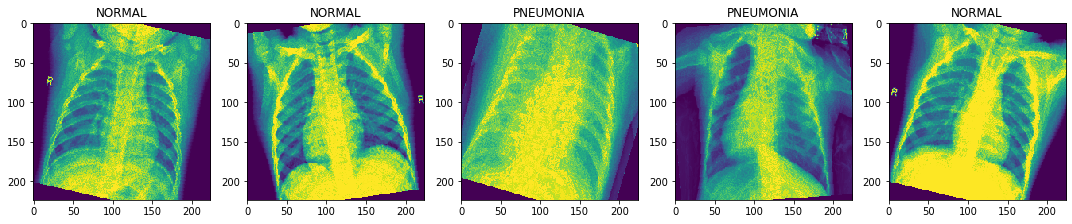

In [21]:
mostrar_imagenes(5)

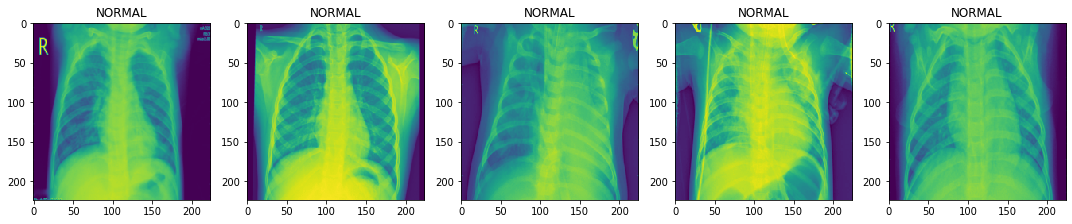

In [22]:
mostrar_imagenes(5, 'test')

## Parte 2

In [88]:
pneumonia_train = 0
normal_train = 0
for x in data_train:
    if x[1] == 0:
        normal_train += 1
    else:
        pneumonia_train += 1

In [312]:
print('TRAIN DATA -', 'NORMAL: {},'.format(normal_train), 'PNEUMONIA: {},'.format(
    pneumonia_train), 'TOTAL: {}'.format(normal_train + pneumonia_train))

TRAIN DATA - NORMAL: 1349, PNEUMONIA: 3883, TOTAL: 5232


In [313]:
pneumonia_test = 0
normal_test = 0
for x in data_test:
    if x[1] == 0:
        normal_test += 1
    else:
        pneumonia_test += 1

KeyboardInterrupt: 

In [311]:
print('TEST DATA -', 'NORMAL: {}'.format(normal_test),
      'PNEUMONIA: {}'.format(pneumonia_test), 'TOTAL: {}'.format(normal_test + pneumonia_test))

TEST DATA - NORMAL: 234 PNEUMONIA: 390 TOTAL: 624


Realizamos visualizaciones

In [267]:
datos_train = {'TRAIN' : [normal_train, pneumonia_train],
               'TEST' : [normal_test, pneumonia_test]}
index = ['NORMAL', 'PNEUMONIA']

df = pd.DataFrame(datos_train, index = index)

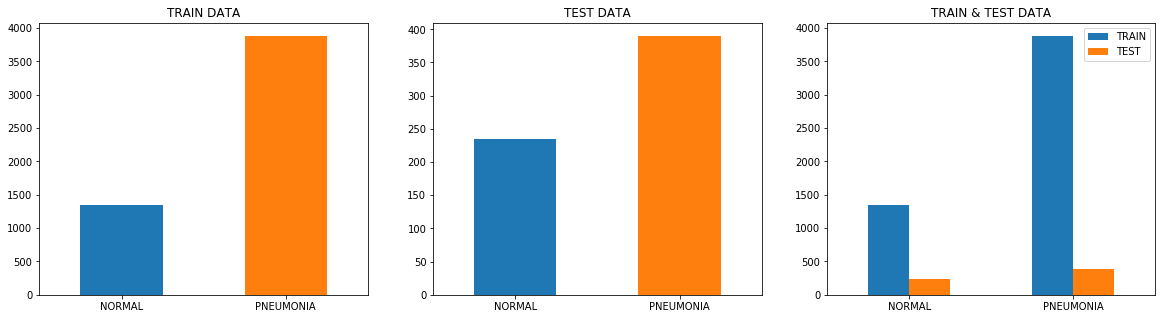

In [276]:
fig, ax = plt.subplots(1,3, figsize = (20,5))

# Plot
df['TRAIN'].plot(ax = ax[0],color=['C0','C1'], kind='bar', rot=0)
df['TEST'].plot(ax = ax[1],color=['C0','C1'], kind = 'bar', rot=0)
df.plot(ax = ax[2], kind = 'bar',rot=0)

# Títulos
ax[0].title.set_text('TRAIN DATA')
ax[1].title.set_text('TEST DATA')
ax[2].title.set_text('TRAIN & TEST DATA')
plt.show()

## Parte 3

Separamos en conjunto de entrenamiento y validación de 80% y 20% del total de los datos.

In [328]:
from sklearn.model_selection import train_test_split

X = np.array([np.asarray(obs[0]) for obs in data_train])
y = np.array([obs[1] for obs in data_train])

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = .2)

In [ ]:
class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    def __init__(self, etiquetas_prueba, indices_val, etiquetas_val):
        self.etiquetas_prueba = etiquetas_prueba
        self.indices_val = indices_val
        self.etiquetas_val = etiquetas_val
        
    def __iter__(self):
        p_test = np.sum(self.etiquetas_prueba)/len(self.etiquetas_prueba) # prob de ser 1, en testeo
        if p_test < 0.5:
            p_vect = self.etiquetas_val 
        else:
            p_vect = 1 - self.etiquetas_val
        p_vect = p_vect/np.sum(p_vect) # debe sumar 1
        sampleo = self.indices_val
        sampleo_eti = self.etiquetas_val
        p_sampleo = np.sum(sampleo_eti)/len(sampleo_eti)
        while abs(p_sampleo - p_test) > 1e-3:
            index = np.random.choice(self.indices_val, size=1, p=p_vect)
            sampleo = np.append(sampleo, index)
            sampleo_eti = np.append(sampleo_eti, self.etiquetas_val[index])
            p_sampleo = np.sum(sampleo_eti)/len(sampleo_eti)
        return sampleo

parte 4

In [ ]:
from torch.utils.data import DataLoader

# P2. Redes convolucionales profundas

El objetivo de esta secci´on es construir una red neuronal profunda para el problema de clasificaci´on de
im´agenes de rayos X sobre neumon´ıa. Dicha red debe ser implementada en Pytorch.
Se implementa un tipo de capa de convoluci´on conocida como Dephtwise Separable Convolution [2]. Esta
consiste en separar una capa de k filtros de convoluci´on de tama˜no n × n, i.e. definida por k filtros de tama˜no
n × n × c (donde c representa el n´umero de canales) en dos capas de convoluci´on:

In [37]:
class DWSepConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   padding=padding, bias=True) #, groups=in_channels
        
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)

    def forward(self, x):
        x = self.depthwise(x)
        out = F.relu(self.pointwise(x))
        return out

NameError: name 'nn' is not defined

In [25]:
class VGG16DWSep():
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)
        
        self.dwsep1 = DWSepConv2d(64,128,kernel_size = 3, padding = 1)
        self.dwsep2 = DWSepConv2d(128,128,kernel_size = 3, padding = 1)

        self.dwsep3 = DWSepConv2d(128,256,kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(256)
        self.dwsep4 = DWSepConv2d(256,256,kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(256)
        self.dwsep5 = DWSepConv2d(256,256,kernel_size = 3, padding = 1)
        self.mp3 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.dwsep6 = DWSepConv2d(256,512,kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(512)
        self.dwsep7 = DWSepConv2d(512,512,kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dwsep8 = DWSepConv2d(512,512,kernel_size = 3, padding = 1)
        
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(512*49*4,1024)
        self.do1 = nn.Dropout(p=0.7)
        self.lin2 = nn.Linear(1024,512)
        self.do2 = nn.Dropout(p=0.5)
        self.out = nn.Linear(512,2)
        
    def forward(self,x):
        x = x.view(-1,3,224,224)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.dwsep1(x))
        x = F.relu(self.dwsep2(x))
        x = self.pool(x)
        x = F.relu(self.dwsep3(x))
        x = F.relu(self.bn1(x))
        x = F.relu(self.dwsep4(x))
        x = F.relu(self.bn2(x))
        x = F.relu(self.dwsep5(x))
        x = self.pool(x)
        x = F.relu(self.dwsep6(x))
        x = F.relu(self.bn3(x))
        x = F.relu(self.dwsep7(x))
        x = F.relu(self.bn4(x))
        x = F.relu(self.dwsep8(x))
        x = self.pool(x)
        x = self.flat(x)
        x = F.relu(self.lin1(x))
        x = self.do1(x)
        x = F.relu(self.lin2(x))
        x = self.do2(x)
        x = F.relu(self.out(x))
        # x.view(-1, x.size(1))
        return x

In [118]:
# Testeo 
model = VGG16DWSep()
model.forward(data_train[0][0])

tensor([[-0.0907,  0.0623]], grad_fn=<ViewBackward>)

In [2]:
from torchvision import models
model_vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\bbarr/.cache\torch\checkpoints\vgg16-397923af.pth


In [19]:
weight_layer1, weight_layer2 = model_vgg16.features[0].weight, model_vgg16.features[2].weight

# Congelamos las capas
weight_layer1.requires_grad, weight_layer2.requires_grad = False, False

In [23]:
class VGG16DWSep():
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)
        
        #  Capas modificadas
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1.weight = weight_layer1
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv1.weight = weight_layer2
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)
        
        self.dwsep1 = DWSepConv2d(64,128,kernel_size = 3, padding = 1)
        self.dwsep2 = DWSepConv2d(128,128,kernel_size = 3, padding = 1)

        self.dwsep3 = DWSepConv2d(128,256,kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(256)
        self.dwsep4 = DWSepConv2d(256,256,kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(256)
        self.dwsep5 = DWSepConv2d(256,256,kernel_size = 3, padding = 1)
        self.mp3 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.dwsep6 = DWSepConv2d(256,512,kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(512)
        self.dwsep7 = DWSepConv2d(512,512,kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dwsep8 = DWSepConv2d(512,512,kernel_size = 3, padding = 1)
        
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(512*49*4,1024)
        self.do1 = nn.Dropout(p=0.7)
        self.lin2 = nn.Linear(1024,512)
        self.do2 = nn.Dropout(p=0.5)
        self.out = nn.Linear(512,2)
        
    def forward(self,x):
        x = x.view(-1,3,224,224)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.dwsep1(x))
        x = F.relu(self.dwsep2(x))
        x = self.pool(x)
        x = F.relu(self.dwsep3(x))
        x = F.relu(self.bn1(x))
        x = F.relu(self.dwsep4(x))
        x = F.relu(self.bn2(x))
        x = F.relu(self.dwsep5(x))
        x = self.pool(x)
        x = F.relu(self.dwsep6(x))
        x = F.relu(self.bn3(x))
        x = F.relu(self.dwsep7(x))
        x = F.relu(self.bn4(x))
        x = F.relu(self.dwsep8(x))
        x = self.pool(x)
        x = self.flat(x)
        x = F.relu(self.lin1(x))
        x = self.do1(x)
        x = F.relu(self.lin2(x))
        x = self.do2(x)
        x = F.relu(self.out(x))
        return x.view(-1, x.size(1))

In [36]:
class EarlyStopping():
    def __init__(self, modo='min', paciencia=5, porcentaje=False, tol=0):
        self.modo = modo
        self.paciencia = paciencia
        self.porcentaje = porcentaje
        self.tol = tol
        self.observacion = None
        self.epocas = None

    def mejor(self, metrica_validacion):
        '''
        Retorna True si metrica_validacion es mejor que la observación.
        '''
        if self.observacion is None:
            self.observacion = metrica_validacion
            self.epocas = 1
            return True

        diferencia = metrica_validacion - self.observacion
        cuociente = metrica_validacion/self.observacion

        if modo == 'min':
            if self.porcentaje:
                # Si el cuociente empeoro en 40% = 0.4
                if cuociente < tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False
            else:
                # Si la metrica es mejor..
                if diferencia < tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False

        else:  # if modo == 'max'
            if self.porcentaje:
                if cuociente > 1+tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False
            else:
                if diferencia > tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False

    def deberia_parar(self, metrica_validacion):
        # Si estoy al límite y no mejoré
        if self.epocas == self.paciencia and not mejor(self, metrica_validacion):
            return True
        return False